## Setup: imports, DM test, lag selection, data loading

In [8]:
from __future__ import annotations
import math
import warnings
from typing import Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.api import VAR

warnings.filterwarnings("ignore")


# ----------------------------
# Diebold–Mariano test
# ----------------------------
def _normal_cdf(z: float) -> float:
    return 0.5 * (1 + math.erf(z / math.sqrt(2)))


def dm_test(
    y_true: pd.Series,
    y_model: pd.Series,
    y_rw: pd.Series,
    h: int = 1,
    loss: str = "mse",
) -> Tuple[float, float]:
    df = pd.concat({"y": y_true, "m": y_model, "rw": y_rw}, axis=1).dropna()
    if len(df) < 5:
        return float("nan"), float("nan")

    e_m = df["y"] - df["m"]
    e_r = df["y"] - df["rw"]
    d = (e_m**2 - e_r**2) if loss == "mse" else (np.abs(e_m) - np.abs(e_r))

    N = len(d)
    d_mean = d.mean()
    var_bar = np.var(d, ddof=1) / N

    # HAC adjustment for overlapping horizons
    if h > 1 and N > 2:
        for k in range(1, min(h - 1, N - 1) + 1):
            w = 1 - k / h
            cov = np.cov(d[k:], d[:-k], ddof=1)[0, 1]
            var_bar += 2 * w * cov / N

    if not np.isfinite(var_bar) or var_bar <= 0:
        return float("nan"), float("nan")

    dm_stat = d_mean / np.sqrt(var_bar)
    p_val = 2 * (1 - _normal_cdf(abs(dm_stat)))
    return dm_stat, p_val


# ----------------------------
# VAR lag selection
# ----------------------------
def choose_var_lag(
    train_endog: pd.DataFrame,
    max_p: int,
    prev_p: Optional[int] = None,
) -> int:
    T, k = train_endog.shape
    p_feasible = max(1, min(max_p, (T - 1) // (k + 1)))

    try:
        sel = VAR(train_endog).select_order(maxlags=p_feasible)
        p = sel.selected_orders.get("aic")
    except Exception:
        p = None

    if p is None:
        p = prev_p if prev_p is not None else min(2, p_feasible)

    return int(max(1, min(p, p_feasible)))


# ----------------------------
# Load monthly dataset
# ----------------------------
url = (
    "https://raw.githubusercontent.com/bredeespelid/"
    "Data_MasterOppgave/refs/heads/main/Variables/All_Variables/variables_monthly.csv"
)

df_raw = pd.read_csv(url)

# Standardise date index
if "Date" in df_raw.columns:
    df_raw["Date"] = pd.to_datetime(df_raw["Date"])
elif "DATE" in df_raw.columns:
    df_raw["Date"] = pd.to_datetime(df_raw["DATE"])
else:
    raise KeyError("Missing 'Date' column.")

df_raw = df_raw.sort_values("Date").set_index("Date")

print(f"Monthly data: {df_raw.index.min().date()} → {df_raw.index.max().date()}")
print(f"Total rows   : {len(df_raw)}")

# Endogenous and exogenous blocks
endog_vars = ["s", "d_pi", "dI_t", "Q"]
exog_vars = ["Brent", "VIX", "StoxEurope", "SP500", "OSEBX", "OBX_Energy"]

required_cols = ["EUR_NOK", "d_pi", "dI_t", "Q"] + exog_vars
missing = [c for c in required_cols if c not in df_raw.columns]
if missing:
    raise KeyError(f"Missing required columns: {missing}")

# Numeric enforcement
for c in required_cols:
    df_raw[c] = pd.to_numeric(df_raw[c], errors="coerce")

# Build log-spot and align blocks
df = df_raw.copy()
df["s"] = np.log(df["EUR_NOK"])
df_all = df[endog_vars + exog_vars].dropna()

endog = df_all[endog_vars]
exog  = df_all[exog_vars]
dates = endog.index

print("\nEndogenous variables:", endog_vars)
print("Exogenous variables : ", exog_vars)
print(f"Usable observations : {len(endog)}")


Monthly data: 2000-01-31 → 2025-11-30
Total rows   : 311

Endogenous variables: ['s', 'd_pi', 'dI_t', 'Q']
Exogenous variables :  ['Brent', 'VIX', 'StoxEurope', 'SP500', 'OSEBX', 'OBX_Energy']
Usable observations : 311


## Quarterly VARX walk-forward


Quarterly VARX – Walk-forward forecast (EUR/NOK)
Completed 91 forecasts.

=== Quarterly VARX Performance (EUR/NOK) ===
Observations: 91
RMSE: 0.306458
MAE : 0.228588
Directional accuracy: 66.7%

=== Diebold–Mariano vs Random Walk (Quarterly VARX) ===
DM statistic: 0.9297
p-value     : 0.3525


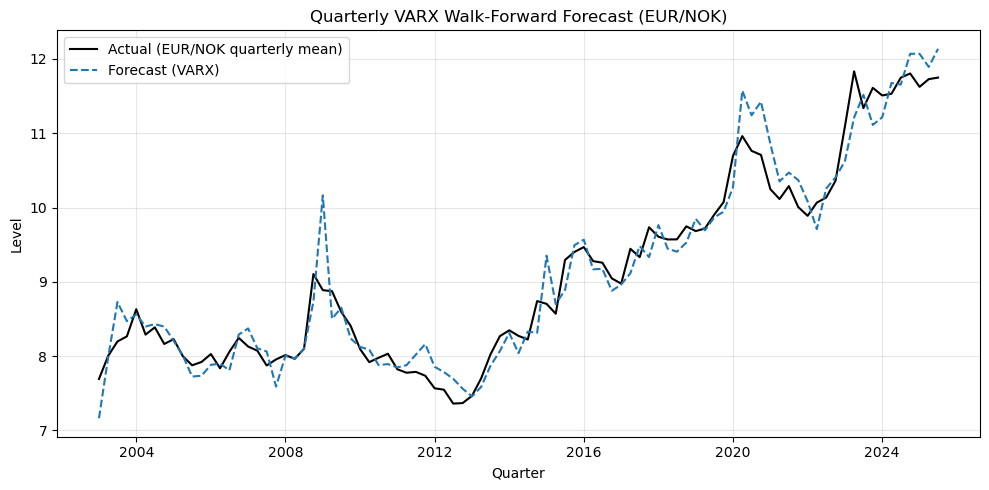


Average selected VARX lag (quarterly): 2.00
Saved plot: VARX_quarterly_forecast.png


In [9]:
min_train_months = 36
max_p = 6

quarter_ends = endog.index[endog.index.is_quarter_end]

rows_qx = []
prev_p_quarterly = None

for q_idx in range(1, len(quarter_ends)):
    origin = quarter_ends[q_idx - 1]

    # Ensure enough history
    if origin < dates[min_train_months - 1]:
        continue

    # Next-quarter horizon (3 months)
    q_start = origin + pd.offsets.MonthEnd(1)
    q_end   = origin + pd.offsets.MonthEnd(3)
    if q_end > endog.index.max():
        break

    # Training window
    endog_train = endog.loc[:origin]
    exog_train  = exog.loc[:origin]

    # Future exog for the next 3 months
    future_mask = (exog.index > origin) & (exog.index <= q_end)
    exog_future = exog.loc[future_mask]

    if len(exog_future) != 3:
        continue

    # Lag selection
    p_q = choose_var_lag(endog_train, max_p=max_p, prev_p=prev_p_quarterly)
    prev_p_quarterly = p_q

    # Fit and 3-step forecast
    model_q = VAR(endog_train, exog=exog_train).fit(p_q)
    y0_q = endog_train.values[-p_q:]
    f_path = model_q.forecast(y=y0_q, steps=3, exog_future=exog_future.values)

    path_df = pd.DataFrame(f_path, index=exog_future.index, columns=endog_vars)
    y_pred_q = float(np.exp(path_df["s"]).mean())   # predicted quarterly level

    # Realised quarterly mean
    true_slice = df.loc[q_start:q_end, "EUR_NOK"]
    if true_slice.empty:
        continue
    y_true_q = float(true_slice.mean())

    # Random walk benchmark
    y_rw_q = float(np.exp(endog_train.loc[origin, "s"]))

    rows_qx.append(
        {
            "quarter_end": q_end,
            "origin": origin,
            "y_true_q": y_true_q,
            "y_pred_q": y_pred_q,
            "y_rw_q": y_rw_q,
            "p_used_q": p_q,
        }
    )

df_eval_qx = pd.DataFrame(rows_qx).set_index("quarter_end").sort_index()


print("\n==============================")
print("Quarterly VARX – Walk-forward forecast (EUR/NOK)")
print("==============================")
print(f"Completed {len(df_eval_qx)} forecasts.")


# ---------------- Quarterly evaluation ----------------
def evaluate_quarterly_varx(df_eval_qx: pd.DataFrame) -> pd.DataFrame:
    df = df_eval_qx.copy()
    df["err"] = df["y_true_q"] - df["y_pred_q"]
    core = df.dropna(subset=["y_true_q", "y_pred_q"])

    rmse = float(np.sqrt(np.mean(core["err"]**2))) if len(core) else np.nan
    mae  = float(mean_absolute_error(core["y_true_q"], core["y_pred_q"])) if len(core) else np.nan

    # Directional accuracy
    core["y_prev"] = core["y_true_q"].shift(1)
    mask = core["y_prev"].notna()
    dir_true = np.sign(core.loc[mask, "y_true_q"] - core.loc[mask, "y_prev"])
    dir_pred = np.sign(core.loc[mask, "y_pred_q"] - core.loc[mask, "y_prev"])
    hit_rate = (dir_true == dir_pred).mean() if mask.any() else np.nan

    print("\n=== Quarterly VARX Performance (EUR/NOK) ===")
    print(f"Observations: {len(core)}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE : {mae:.6f}")
    if mask.any():
        print(f"Directional accuracy: {hit_rate*100:.1f}%")

    out = core.rename(columns={"y_true_q": "y_true", "y_pred_q": "y_pred"})
    out.index = out.index.to_period("Q")
    return out


# ---------------- DM Test ----------------
def dm_against_random_walk_quarterly_varx(eval_df: pd.DataFrame, loss: str = "mse", h: int = 1):
    df = eval_df.copy()
    df["rw_pred"] = df["y_true"].shift(1)

    dm_stat, p_val = dm_test(df["y_true"], df["y_pred"], df["rw_pred"], h=h, loss=loss)

    print("\n=== Diebold–Mariano vs Random Walk (Quarterly VARX) ===")
    print(f"DM statistic: {dm_stat:.4f}" if np.isfinite(dm_stat) else "DM statistic: nan")
    print(f"p-value     : {p_val:.4f}" if np.isfinite(p_val) else "p-value     : nan")


# Run evaluation + DM
eval_qx = evaluate_quarterly_varx(df_eval_qx)
dm_against_random_walk_quarterly_varx(eval_qx)


# ---------------- Plot ----------------
plt.figure(figsize=(10, 5))

x_q = eval_qx.index.to_timestamp()

plt.plot(
    x_q,
    eval_qx["y_true"],
    label="Actual (EUR/NOK quarterly mean)",
    color="black",
)

plt.plot(
    x_q,
    eval_qx["y_pred"],
    "--",
    label="Forecast (VARX)",
)

plt.title("Quarterly VARX Walk-Forward Forecast (EUR/NOK)")
plt.xlabel("Quarter")
plt.ylabel("Level")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save PNG file
plt.savefig("VARX_quarterly_forecast.png", dpi=300, bbox_inches="tight")

plt.show()

print(f"\nAverage selected VARX lag (quarterly): {df_eval_qx['p_used_q'].mean():.2f}")
print("Saved plot: VARX_quarterly_forecast.png")

